# 【第３回　課題1】 DeepDream

In [1]:
# UEC環境での初期設定
import os
# CED/IEDでの proxy の設定．
# keras.datasetsやkeras.applicationsでは，dataset, pretrained modelを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"      # "0":GPU0,..., "7":GPU7 を使用

# CED/IEDを自動判定して，datadir をセット．
cdir=os.getcwd()
if '/IED_HOME/' in cdir or '/.ced_ubuntu/' in cdir:
    datadir="/ced-home/staff/yanai/media/"
else:
    datadir="/usr/local/class/object/media/"
       
# 結果を出力するディレクトリを作成
outdir='result'
os.makedirs(outdir, exist_ok=True)

In [2]:
import keras

Using TensorFlow backend.


using GPU: 1


前回の最後の課題に，CNNが画像のどの部分に注目して認識を行ったかを可視化するGradCAMという方法を試してもらいました．

今回は最初の課題も可視化の一種ですが，特殊な可視化です．特定のカテゴリの認識信号をより強めるように画像を変化させるというものです．学習では目的関数の値が減少するようにネットワークのパラメータを更新するのが一般的ですが，実は入力画像の値を更新することもできます．認識ネットワーク中の信号の強い部分をさらに強めるように画像を変化させると，画像中の「OOっぽい部分」が本当にOOになった画像が現れます．それが，2015年くらいに話題になった [DeepDream](https://matome.naver.jp/odai/2143609640846730901) です．通常は新しい技術は論文として発表されますが，実はDeepDreamの論文は存在せず，[Google AIのBlog](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) で発表されました．

ここでは，DeepDreamを試してみましょう．

なお，コードは，Kerasの作者による「[Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff)」のものを利用しています．

### 学習済みネットワークの選択

通常は，[ImageNet1000種類](./1000.txt)で事前学習されたネットワークを使います．前回利用したVGG16やResNet50でも可能ですが，ここではGoogleの開発した InceptionV3 を使ってみます．
初回はダウンロードが必要ですので，すこし時間がかかりますので，注意してください．

In [3]:
from keras.applications import inception_v3
from keras import backend as K

# We will not be training our model,
# so we use this command to disable all training-specific operations
K.set_learning_phase(0)

# Build the InceptionV3 network.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

DeepDream では，Gradient Decent ではなくて，現在の信号をさらに強める Gradient Ascent を使います．実際には，勾配に学習率をかけてそれを引くのではなく，勾配に学習率をかけてそれを画像のピクセル値に加算して，画像を変化させていきます．

ここでは，どのレイヤをどの程度，強めるかを指定します．

model.summary() とすればわかりますが，mixedは0から10まであります．以下の Inception V3の図の 枝分かれして１つに戻った直後のオレンジのノード(11個あります)が，mixed0..10 です．

![Google のサイトにあるInception V3 の図](img/inceptionv3.png)

以下では，このうち，mixed2, mixed3, mixed4, mixed5 の信号を以下に指定した割合 0.2, 3.0, 2.0, 1.5 で強めます．
この割合は，経験的に決めているので，これに限定する必要は全くありません．自由に変えてみて，結果がどうなるか観察するといいでしょう．

In [4]:
# Dict mapping layer names to a coefficient quantifying how much the layer's activation
# will contribute to the loss we will seek to maximize.
# Note that these are layer names as they appear in the built-in InceptionV3 application.
# You can list all layer names using `model.summary()`.
layer_contributions = {
  'mixed2': 0.2,
  'mixed3': 3.0,
  'mixed4': 2.0,
  'mixed5': 1.5,
#    'mixed7': 1.0,
#    'mixed9': 1.0
}

損失関数に，上記のレイヤの（重みではなくて）信号値の２乗和を上記の重みを掛けて加えます．

Gradient ascentなので，この損失関数を最大化するように画像の画素値をアップデートしていきます．

In [5]:
# Get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in layer_contributions:
    # Add the L2 norm of the features of a layer to the loss.
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

勾配上昇 (gradient ascent) の計算を行います．

画像をアップデートすることで，指定したmixed layerの強い信号がますます強まります．
つまり，少しでもOOっぽかったものが，よりOOっぽくなります．

In [6]:
# This holds our generated image
dream = model.input

# Compute the gradients of the dream with regard to the loss.
grads = K.gradients(loss, dream)[0]

# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

ここでは，さらに dream度を高めるために，下図のようにgradient ascentで画像を更新したら，さらに画像を1.4倍に拡大して画像を更新して，さらにもう一度，1.4に拡大して更新しています．物体のスケールはフィルタ毎に決まっているため，いろいろなスケールの dream を登場させるために，2回拡大しています．さらに拡大したら，元の画像を再注入(reinjection)してやることによって，gradinet ascentによって失われた細部の構造が元に戻って，拡大したスケールでも dream が起こりやすくなります．（かなりの高等テクニックです．) そして，最後には 640x480 に画像サイズを戻します．

![deep dream process](https://s3.amazonaws.com/book.keras.io/img/ch8/deepdream_process.png)

In [7]:
import scipy
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    scipy.misc.imsave(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = img.resize((640,480))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [8]:
import numpy as np

# Playing with these hyperparameters will also allow you to achieve new effects

step = 0.01  # Gradient ascent step size
num_octave = 3  # Number of scales at which to run gradient ascent
octave_scale = 1.4  # Size ratio between scales
iterations = 100 # Number of ascent steps per scale  ### Gradient ascentの繰り返し回数．

# If our loss gets larger than 10,
# we will interrupt the gradient ascent process, to avoid ugly artifacts
max_loss = 10.

# Fill this to the path to the image you want to use (画像ファイル名の指定)
base_image_path = 'img/tamon.jpg'

# Load the image into a Numpy array
img = preprocess_image(base_image_path)

# We prepare a list of shape tuples
# defining the different scales at which we will run gradient ascent
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    # save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

#save_img(img, fname='final_dream.png')

Processing image shape (244, 326)
...Loss value at 0 : 1.8853346
...Loss value at 1 : 2.3844118
...Loss value at 2 : 3.0478876
...Loss value at 3 : 3.6652627
...Loss value at 4 : 4.243375
...Loss value at 5 : 4.7496305
...Loss value at 6 : 5.2820706
...Loss value at 7 : 5.7497253
...Loss value at 8 : 6.2440104
...Loss value at 9 : 6.715645
...Loss value at 10 : 7.187405
...Loss value at 11 : 7.643988
...Loss value at 12 : 8.071953
...Loss value at 13 : 8.487425
...Loss value at 14 : 8.911098
...Loss value at 15 : 9.296275
...Loss value at 16 : 9.721866
Processing image shape (342, 457)
...Loss value at 0 : 3.0709562
...Loss value at 1 : 4.4708962
...Loss value at 2 : 5.5541863
...Loss value at 3 : 6.475617
...Loss value at 4 : 7.377672
...Loss value at 5 : 8.104116
...Loss value at 6 : 8.877064
...Loss value at 7 : 9.567605
Processing image shape (480, 640)
...Loss value at 0 : 3.4044592
...Loss value at 1 : 4.7797885
...Loss value at 2 : 5.967971
...Loss value at 3 : 7.0716987
...Loss

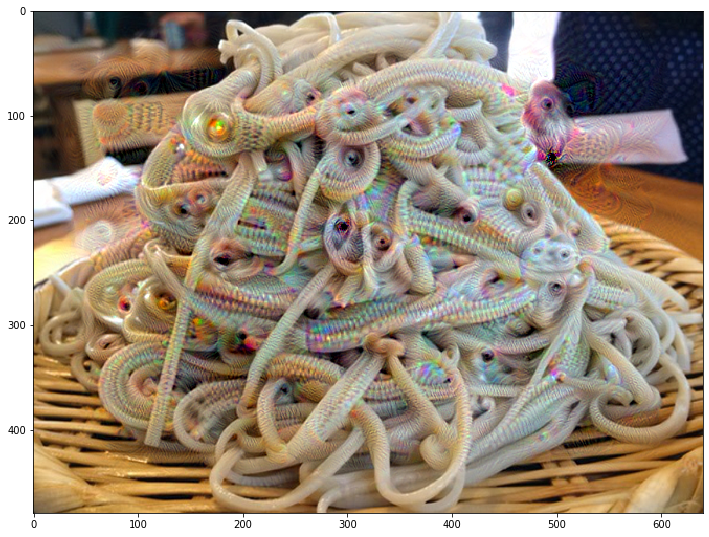

In [9]:
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline
from IPython import display

plt.figure(figsize=(12, 12))
out=deprocess_image(np.copy(img))
plt.imshow(out)
plt.show()

Image.fromarray(out).save(outdir+'/final_dream1.png')

## 課題1
以下の小問の(1)-(2)を解答せよ．

1. 上記の蕎麦画像以外の任意の画像2枚について変換してみよ．
1. mixed2からmixed5までを強調しているが，その割合を変えるとどうなるか試してみよ．例えば，mixed2とmixed3だけにしてみよ．

この設問の後に，適宜セルを追加して，Markdownで回答せよ．（解答シートを利用せよ．）

 !［］(result/final_dream1.png) 
 
などとして，結果の画像を挿入しつつ，簡単な説明もつけよ．

![](result/final_dream1.png)

In [10]:
# GPUメモリの開放
from numba import cuda
cuda.select_device(0)
cuda.close()